In [1]:
# Utility
from tqdm.notebook import tqdm
from typing import Union
import os

# Math and data manipulation
import numpy as np
import pandas as pd 
import random

# Datetime object manipulation
from datetime import datetime as dt

# Data Visualization
import matplotlib.pyplot as plt

# Data preprocessing

# Machine learning model
import tensorflow as tf

# Model Evaluation
from sklearn.metrics import mean_squared_error as MSE

# Parameter
SEED = 986
N_EPOCH = 100
TRAIN_SIZE = 0.7
DARK_THEME = 0
PLOT_SIZE = (16,7)

#Set Seed
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Set Plot Configuration
if DARK_THEME:
    import mplcyberpunk
    plt.style.use('cyberpunk')
else:
    plt.style.use('seaborn-v0_8')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

plt.rcParams['figure.figsize'] = PLOT_SIZE 
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
data = pd.read_csv('Data/Data Inflasi.csv', dayfirst=True, parse_dates=[0])[::-1]
data = data.set_index('Periode')

In [3]:
data.describe()

,Data Inflasi
count,240.000000
mean,5.705417
std,3.347665
min,1.320000
25%,3.345000
50%,5.080000
75%,6.990000
max,18.380000


In [4]:
train = data[:int(len(data)*TRAIN_SIZE)]
test = data[int(len(data)*TRAIN_SIZE):]

In [5]:
train.describe()

,Data Inflasi
count,168.000000
mean,6.876488
std,3.301116
min,2.410000
25%,4.577500
50%,6.330000
75%,7.465000
max,18.380000


In [6]:
test.describe()

,Data Inflasi
count,72.000000
mean,2.972917
std,1.129572
min,1.320000
25%,1.937500
50%,3.130000
75%,3.505000
max,5.950000


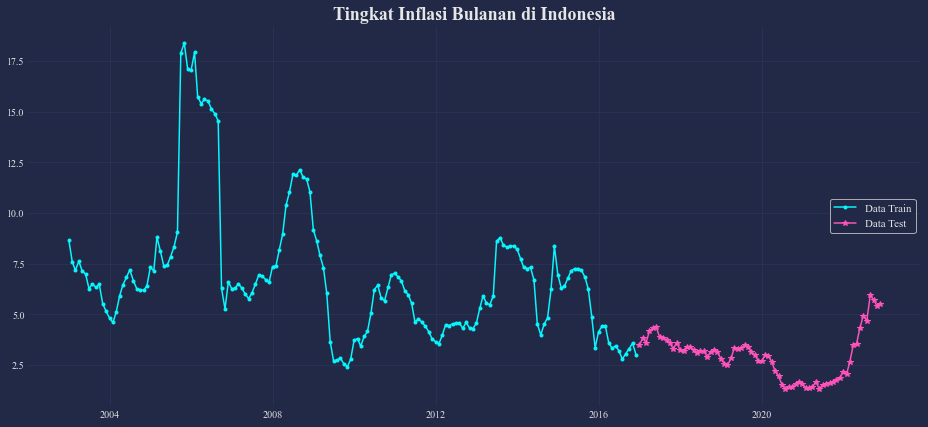

In [7]:
plt.title('Tingkat Inflasi Bulanan di Indonesia', 
            fontdict={"size":18, 'weight':'bold'}
            )
plt.plot(train, label='Data Train',marker='.')
plt.plot(test, label='Data Test', marker='*')
plt.legend(prop={'size':11}, frameon=True, loc='center right')
plt.show()

In [8]:
def partition(sequence_length, data):
    """Function to

    Args:
        sequence_length (_type_): _description_
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    x, y = [], []
    data = np.array(data)
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i])
        y.append(data[i:i+1])
    
    x = np.array(x)
    y = np.array(y)
    return x, y

In [62]:
architectures = []
base = (5,5,5)
for i in range(-1,2):
    for j in range(-1,2):
        architectures.append([base[0]+i]*(len(base)+j))

In [10]:
def create_model(architecture: Union[tuple,list], seed=42):
    """Creating tensorflow model easier

    Args:
        architecture (tuple | list): Architecture of ANN model
        seed (int, optional): Random number seed. Defaults to 42.

    Returns:
        model: Tensorflow model
    """
    
    model = tf.keras.models.Sequential(
        tf.keras.layers.Flatten()
    )

    initializer = tf.keras.initializers.he_normal(seed)

    for neuron in architecture[1:]:
        model.add(
            tf.keras.layers.Dense(
                units = neuron, 
                activation = 'relu', 
                kernel_initializer = initializer, 
                )
            )

    model.add(tf.keras.layers.Dense(1))
    # model.add(tf.keras.layers.Reshape([1, -1]),)

    optimizer = tf.keras.optimizers.Adam()

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=optimizer,
        )
    
    return model

In [11]:
def forecast(model, last_data, n):
    y = np.array([])
    len_input = len(last_data[0])

    for i in range(n):
        pred = model.predict(last_data, verbose=0)
        last_data = np.append(last_data[:,1:], pred).reshape(-1, len_input)
        y = np.append(y, pred)
        
    return y

In [12]:
histories = []
models = []
names = []
preds = []
mse = []
seeds= []
for architecture in architectures:
    for i in range(10):
        x_train, y_train = partition(architecture[0], train)
        
        # seed = np.random.randint(1,2500)
        model = create_model(architecture, seed=SEED)

        history = model.fit(
                    x=x_train,
                    y=y_train,
                    epochs=N_EPOCH,
                    verbose=0, 
                )
        
        name = "-".join(map(str, architecture))+'*'+str(i)
        # model.save(f'Model/{name}.h5')

        y_pred = forecast(model, train[-architecture[0]:].values.T, len(test))
        error = MSE(test, y_pred)
        
        histories.append(history.history['loss'][-1])
        # models.append(model)
        # seeds.append(seed)
        names.append(name)
        preds.append(y_pred)
        mse.append(error)


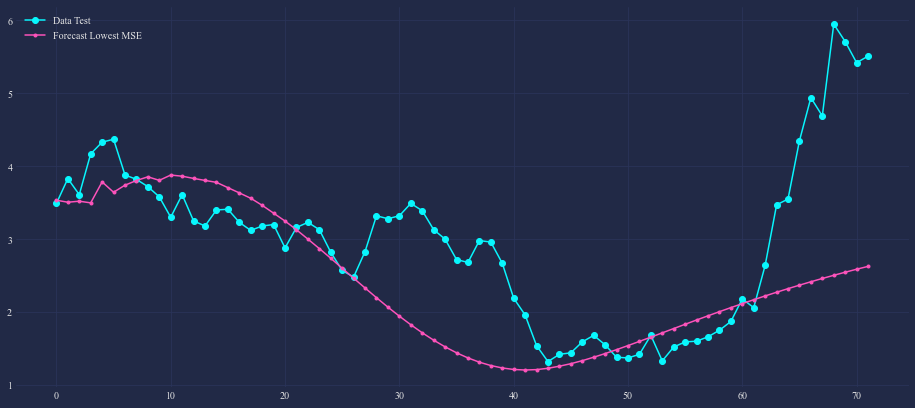

In [13]:
plt.plot(test.values, marker='o', label='Data Test')
plt.plot(preds[mse.index(min(mse))], marker='.', label='Forecast Lowest MSE')
plt.legend()
plt.show()

In [14]:
output = pd.DataFrame(dict(zip(names, preds)))

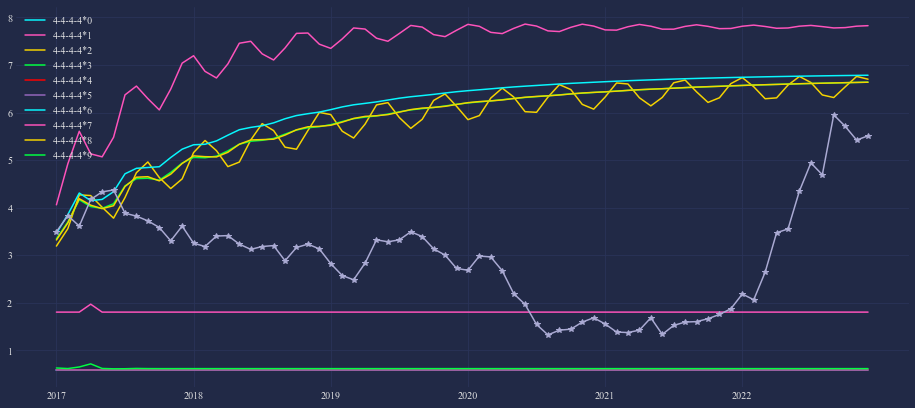

In [23]:
x = 2
ax = output.iloc[:,x*10:(x+1)*10].plot()
plt.plot(test.values, label='Data Test', marker='*', color='#aaaad3')
ax.set_xticks(list(range(0, len(output),12)), list(range(2017,2023)))
# plt.legend()
plt.show()

In [19]:
a = np.array([mse[x*10:(x+1)*10] for x in range(9)])

In [20]:
a.mean(axis=1)

array([  6.69068218,   9.5295063 ,   9.64091293,   6.63469618,
         6.97576646,   7.00226692, 392.64850932,  18.47732801,
        12.39693076])

In [24]:
idx = pd.date_range(test.index[0],freq='MS', periods=len(test))

In [25]:
predict = output.set_index(idx)
predict.index = predict.index.rename('Periode')

In [26]:
predict['Test'] = test

In [27]:
# predict.to_csv('Output/Predict.csv', float_format='%.2f')

In [28]:
# histories = []
models = []
namef= []
future = []
for architecture in architectures:
    x_train, y_train = partition(architecture[0], data)

    model = create_model(architecture, seed=SEED)

    history = model.fit(
                x=x_train,
                y=y_train,
                epochs=N_EPOCH,
                verbose=0, 
            )
    
    name = "-".join(map(str, architecture))
    model.save(f'Model/{name}.h5')

    y_pred = forecast(model, data[-architecture[0]:].values.T,12)
    
    # histories.append(history)
    # models.append(model)
    namef.append(name)
    future.append(y_pred)


In [29]:
futures = pd.DataFrame(dict(zip(namef, future)))

In [30]:
futures = futures.set_index(pd.date_range('1/1/2023',freq='MS',periods=12))
futures.index = futures.index.rename('Periode')

<AxesSubplot: xlabel='Periode'>

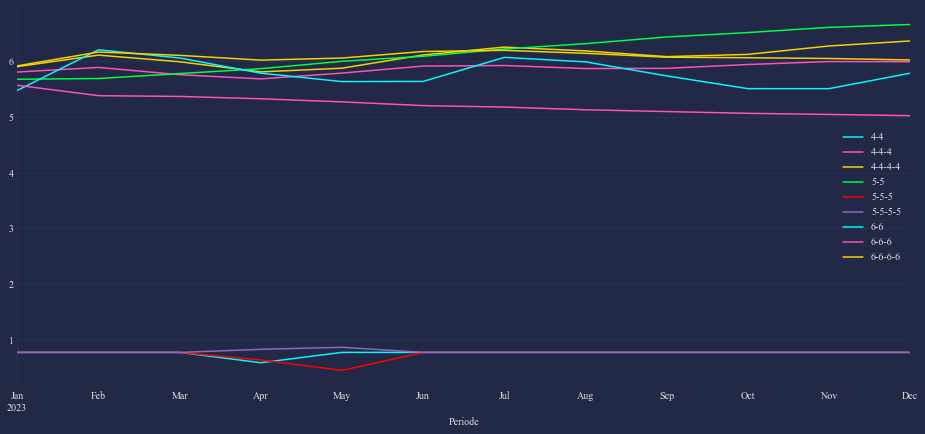

In [31]:
futures.plot()

In [32]:
# futures.to_csv('Output/Forecast.csv', float_format='%.2f')

In [33]:
loop = [mse[i*10:(i+1)*10] for i in range(9)]

In [34]:
mset = pd.DataFrame(dict(zip(namef, loop)))

In [42]:
mset.to_csv('Output/test_mse.csv',float_format='%.2f')

In [43]:
mset.describe().to_csv('Output/test_info.csv', float_format='%.2f')

In [36]:
loss = [histories[i*10:(i+1)*10] for i in range(9)]

In [37]:
losses = pd.DataFrame(dict(zip(namef, loss)))

In [45]:
losses.to_csv('Output/train_mse.csv', float_format='%.2f')

In [44]:
losses.describe().to_csv('Output/train_info.csv', float_format='%.2f')

In [39]:
mset

,4-4,4-4-4,4-4-4-4,5-5,5-5-5,5-5-5-5,6-6,6-6-6,6-6-6-6
0,7.794075,6.991013,6.969033,6.233473,6.950486,6.999972,25.961489,27.415352,1.231790
1,7.045603,9.750864,2.624116,7.421215,6.957711,7.000595,93.251188,8.536508,9.617451
2,7.053145,16.827791,10.518613,5.889392,7.003378,7.001044,3.722246,6.207204,27.316580
3,7.864760,9.524232,10.835673,1.266358,6.997374,7.000591,6.952243,14.060018,14.965069
4,6.990432,6.994497,6.965693,3.525435,6.981821,7.009187,809.726191,29.310400,5.213914
5,6.905848,6.964620,6.970882,6.862661,6.922382,7.004238,2907.814296,39.073737,30.507958
6,7.595998,10.592394,12.223392,7.967625,6.957490,6.998587,12.720193,4.549550,8.070050
7,1.399100,6.978031,21.637837,7.127599,7.015106,7.009415,3.565004,7.345378,14.762348
8,7.209272,10.125368,10.838483,11.505161,6.954960,6.999509,20.063133,42.616448,1.871347
9,7.048588,10.546254,6.825407,8.548043,7.016956,6.999533,42.709111,5.658685,10.412801


In [2]:
a = pd.read_csv('Output/Predict.csv',parse_dates=[0])

In [3]:
a = a.set_index('Periode')

<AxesSubplot: xlabel='Periode'>

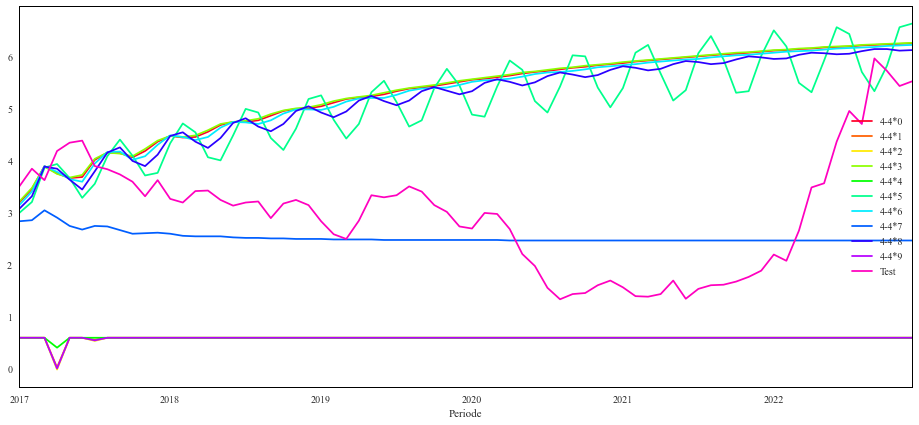

In [4]:
a.iloc[:,list(range(10))+[-1]].plot(colormap='gist_rainbow')

In [65]:
name = list(map(lambda x: "-".join(map(str, x)), architectures))

In [67]:
name

['4-4',
 '4-4-4',
 '4-4-4-4',
 '5-5',
 '5-5-5',
 '5-5-5-5',
 '6-6',
 '6-6-6',
 '6-6-6-6']

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

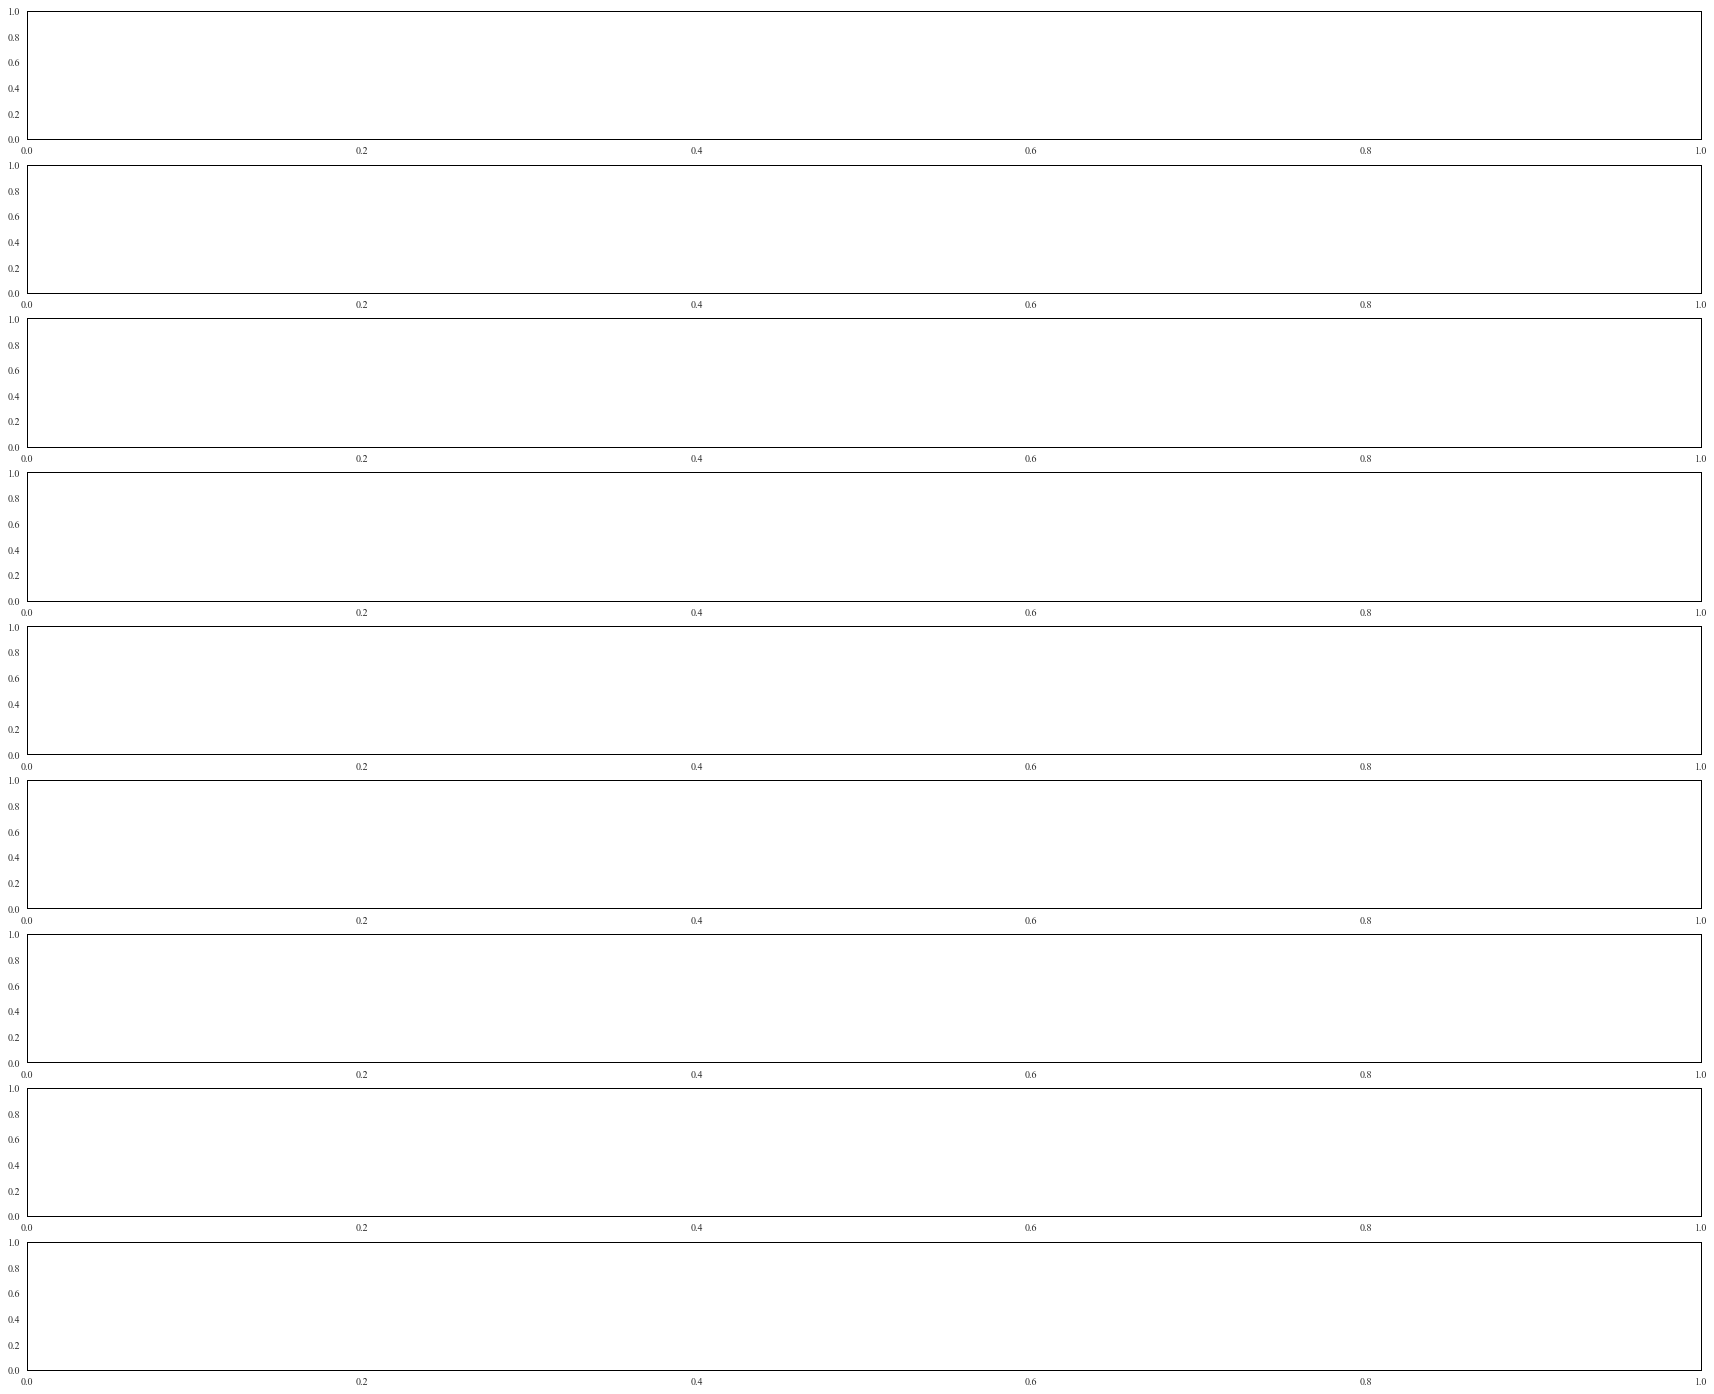

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30,25))
for i in range(3):
    for j in range(3):
        rng = (i*3)+j
        a.iloc[:,list(range(rng*10,(rng+1)*10))+[-1]]\
            .plot(
                colormap='gist_rainbow',
                ax=axes[i,j], title=name[rng]+'-1'
                )
fig.suptitle('Peramalan Data Test', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)


In [74]:
a.values.sort()

In [75]:
a

,4-4*0,4-4*1,4-4*2,4-4*3,4-4*4,4-4*5,4-4*6,4-4*7,4-4*8,4-4*9,...,6-6-6-6*1,6-6-6-6*2,6-6-6-6*3,6-6-6-6*4,6-6-6-6*5,6-6-6-6*6,6-6-6-6*7,6-6-6-6*8,6-6-6-6*9,Test
Periode,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.37,0.55,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.58,...,3.56,3.58,3.58,3.59,3.59,3.62,3.66,3.66,3.67,4.06
2017-02-01,0.17,0.55,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.58,...,3.81,3.83,3.84,3.85,3.91,3.93,3.94,4.04,4.13,4.92
2017-03-01,0.37,0.55,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.58,...,4.10,4.16,4.18,4.19,4.27,4.31,4.35,4.55,4.68,5.61
2017-04-01,-0.03,-0.01,0.01,0.37,0.39,0.41,0.42,0.51,0.51,0.52,...,4.23,4.25,4.25,4.27,4.28,4.36,4.54,4.67,4.88,5.13
2017-05-01,0.37,0.49,0.51,0.55,0.55,0.57,0.57,0.57,0.58,0.58,...,4.49,4.49,4.55,4.56,4.61,4.61,5.02,5.06,5.07,5.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,-44.68,-4.01,-2.63,-0.10,0.02,0.37,0.55,0.58,0.58,0.58,...,8.40,8.41,8.43,8.88,10.24,11.74,11.95,13.26,18.23,44.23
2022-09-01,-0.10,0.03,0.37,0.55,0.58,0.58,0.58,0.58,0.58,0.58,...,8.91,9.68,10.08,10.25,11.79,12.01,14.44,18.90,43.59,190.64
2022-10-01,-50.16,-4.34,-2.67,-0.10,0.02,0.37,0.55,0.58,0.58,0.58,...,7.95,8.39,8.41,8.46,8.95,10.25,11.84,12.07,19.95,42.85
